In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import bartz
from stochtree import BARTModel
from bart_playground import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import arviz as az
import time

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [4]:
from pmlb import fetch_data

X, y = fetch_data('294_satellite_image', return_X_y=True)

In [5]:
X.shape

(6435, 36)

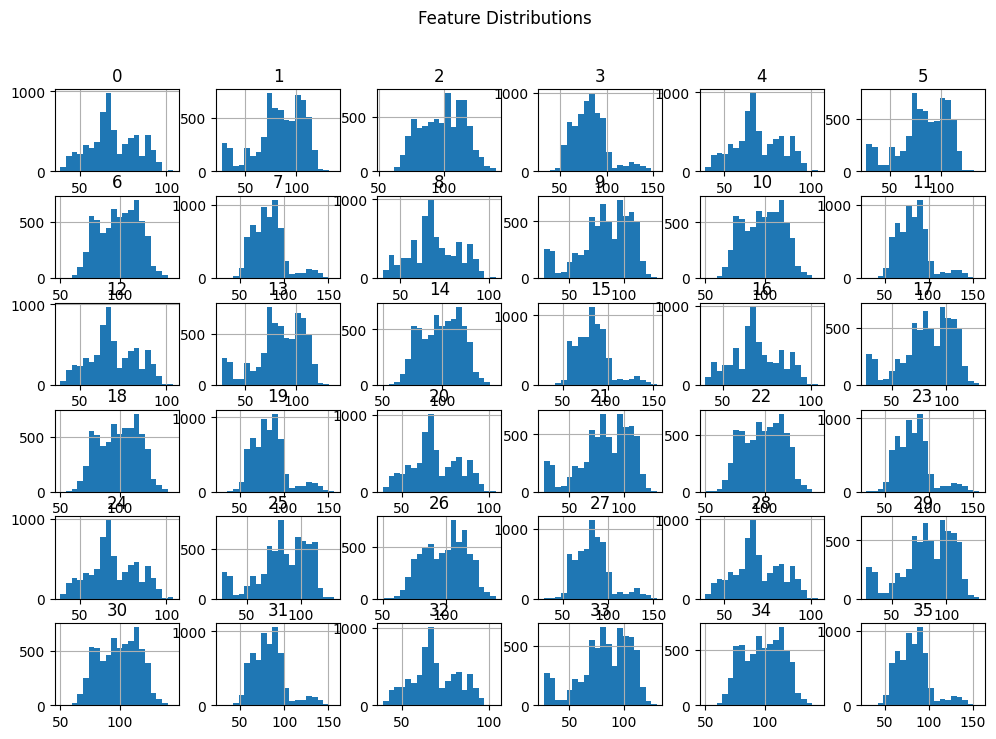

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

X_df = pd.DataFrame(X)
X_df.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

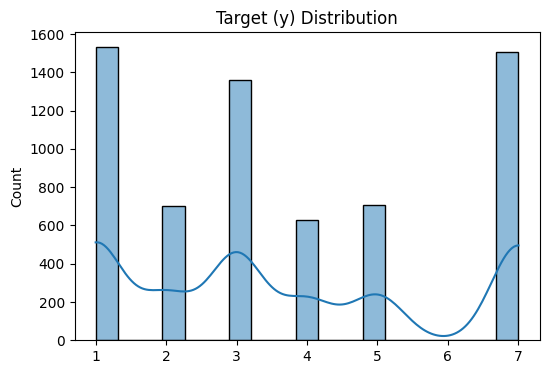

In [7]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

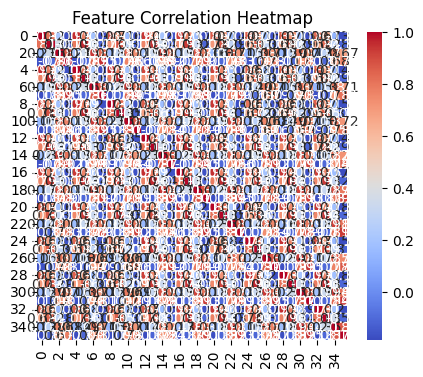

In [8]:
plt.figure(figsize=(5, 4))
corr = X_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [9]:
import comparison
import pandas as pd

proposal_probs_mtmh={"multi_grow": 0.25, "multi_prune": 0.25, "multi_change": 0.4, "multi_swap": 0.1}
proposal_probs_default={"grow": 0.25, "prune": 0.25, "change": 0.4, "swap": 0.1}
rhat_df = comparison.gelman_rubin_r_compare(X, y, n_runs=10, n_chains=4, ndpost=1000, nskip=1000, n_trees=100, 
                                            proposal_probs_mtmh=proposal_probs_mtmh, proposal_probs_default=proposal_probs_default,
                                            n_jobs=-2)
mean_row = pd.DataFrame([rhat_df.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df.std()], index=["std"])
rhat_df_with_stats = pd.concat([rhat_df, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix (all 4):")
print(rhat_df_with_stats)

Gelman-Rubin R̂ comparison matrix (all 4):
      MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
0                  1.744152                 2.113133             1.259497   
1                  1.672823                 1.595743             1.878513   
2                  1.979987                 1.539545             2.367425   
3                  1.726427                 1.610832             1.808218   
4                  1.716858                 1.873965             1.506570   
5                  1.760386                 1.772243             1.871456   
6                  2.351580                 1.590793             1.857278   
7                  1.782237                 2.181543             2.286115   
8                  1.902508                 1.557480             1.503647   
9                  1.980595                 1.635993             1.589930   
mean               1.861755                 1.747127             1.792865   
std                0.204158      

In [10]:
rhat_df.to_csv("results4/real7_Satellite_rhat.csv", index=False)

In [11]:
proposal_probs_mtmh={"multi_grow": 0.5, "multi_prune": 0.5}
proposal_probs_default={"grow": 0.5, "prune": 0.5}
rhat_df2 = comparison.gelman_rubin_r_compare(X, y, n_runs=10, n_chains=4, ndpost=1000, nskip=1000, n_trees=100, 
                                            proposal_probs_mtmh=proposal_probs_mtmh, proposal_probs_default=proposal_probs_default,
                                            n_jobs=-2)
mean_row = pd.DataFrame([rhat_df2.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df2.std()], index=["std"])
rhat_df2_with_stats = pd.concat([rhat_df2, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix (only 2):")
print(rhat_df2_with_stats)

Gelman-Rubin R̂ comparison matrix (only 2):
      MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
0                  1.798673                 2.054353             1.452012   
1                  2.333854                 2.107898             2.236118   
2                  1.661805                 1.696292             2.118466   
3                  1.481667                 1.459492             1.679295   
4                  1.576725                 1.570524             1.801718   
5                  1.792690                 1.859284             1.530355   
6                  1.757839                 2.106742             1.753669   
7                  2.057633                 1.569521             1.134589   
8                  1.967702                 1.662280             2.360371   
9                  1.715387                 2.076309             1.780451   
mean               1.814397                 1.816269             1.784704   
std                0.248709     

In [12]:
rhat_df2.to_csv("results2/real7_Satellite_rhat.csv", index=False)

In [13]:
# Create comparison table with means and standard deviations in parentheses
comparison_table = pd.DataFrame(index=['All 4 Operations', 'Grow/Prune Only'])

# Calculate mean and standard deviation for each column
for col in rhat_df.columns:
    # First row: All 4 operations (grow/prune/change/swap)
    mean_4ops = rhat_df[col].mean()
    std_4ops = rhat_df[col].std()
    comparison_table.loc['All 4 Operations', col] = f"{mean_4ops:.4f} ({std_4ops:.4f})"
    
    # Second row: Only grow/prune operations
    mean_2ops = rhat_df2[col].mean()
    std_2ops = rhat_df2[col].std()
    comparison_table.loc['Grow/Prune Only', col] = f"{mean_2ops:.4f} ({std_2ops:.4f})"

print("Gelman-Rubin R̂ Comparison Table:")
print(comparison_table)

Gelman-Rubin R̂ Comparison Table:
                 MultiBART_Rhat_Sigma2 DefaultBART_Rhat_Sigma2  \
All 4 Operations       1.8618 (0.2042)         1.7471 (0.2349)   
Grow/Prune Only        1.8144 (0.2487)         1.8163 (0.2544)   

                 MultiBART_Rhat_RMSE DefaultBART_Rhat_RMSE  
All 4 Operations     1.7929 (0.3468)       1.8734 (0.3507)  
Grow/Prune Only      1.7847 (0.3737)       1.6555 (0.3217)  


In [14]:
import matplotlib.pyplot as plt
import comparison
import pandas as pd

proposal_probs_mtmh={"multi_grow": 0.25, "multi_prune": 0.25, "multi_change": 0.4, "multi_swap": 0.1}
proposal_probs_default={"grow": 0.25, "prune": 0.25, "change": 0.4, "swap": 0.1}
mse_results = comparison.bart_mse_comparison(X, y, n_runs=10, n_skip=1000, n_post=1000, n_trees=100, n_jobs=5,
                                             proposal_probs_mtmh=proposal_probs_mtmh, proposal_probs_default=proposal_probs_default)
for k, v in mse_results.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")

test_mse:
      bart_mtmh      bart
0      0.612470  0.635462
1      0.692455  0.667001
2      0.544116  0.592937
3      0.648141  0.594618
4      0.585168  0.567955
5      0.612238  0.624565
6      0.588940  0.582452
7      0.578603  0.572490
8      0.637413  0.600191
9      0.675029  0.654972
mean   0.617457  0.609264
std    0.046038  0.034455

pi_length:
      bart_mtmh      bart
0      1.860159  2.281344
1      1.755697  2.275378
2      1.823765  2.366011
3      1.786389  2.346016
4      1.930078  2.403372
5      1.860590  2.428816
6      1.867424  2.370238
7      1.797416  2.370001
8      1.831648  2.349574
9      1.848880  2.364890
mean   1.836205  2.355564
std    0.049170  0.047536

coverage:
      bart_mtmh      bart
0      0.858297  0.880050
1      0.837787  0.883157
2      0.845245  0.893101
3      0.848975  0.899316
4      0.862026  0.896830
5      0.852082  0.890615
6      0.861405  0.891858
7      0.851461  0.893723
8      0.859540  0.904288
9      0.852704  0.881914
mean 

In [15]:
for k, v in mse_results.items():
    csv_name = f"results4/real7_Satellite_{k}.csv"
    v.to_csv(csv_name, index=False)

In [16]:
proposal_probs_mtmh={"multi_grow": 0.5, "multi_prune": 0.5}
proposal_probs_default={"grow": 0.5, "prune": 0.5}
mse_results2 = comparison.bart_mse_comparison(X, y, n_runs=10, n_skip=1000, n_post=1000, n_trees=100, n_jobs=5,
                                             proposal_probs_mtmh=proposal_probs_mtmh, proposal_probs_default=proposal_probs_default)
for k, v in mse_results2.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")

test_mse:
      bart_mtmh      bart
0      0.569979  0.647553
1      0.606640  0.626677
2      0.622440  0.585603
3      0.623073  0.688254
4      0.558004  0.603727
5      0.607848  0.636130
6      0.584928  0.606358
7      0.559326  0.563581
8      0.629110  0.620405
9      0.596354  0.595708
mean   0.595770  0.617400
std    0.026604  0.035059

pi_length:
      bart_mtmh      bart
0      2.145796  2.360842
1      2.095262  2.412008
2      2.193175  2.429134
3      2.104577  2.312560
4      2.131458  2.348547
5      2.118478  2.363472
6      2.137346  2.446587
7      2.116323  2.379780
8      2.111829  2.435467
9      2.156014  2.382567
mean   2.131026  2.387097
std    0.028802  0.042986

coverage:
      bart_mtmh      bart
0      0.881293  0.881293
1      0.876321  0.894966
2      0.872592  0.889372
3      0.875078  0.878185
4      0.878185  0.885643
5      0.871970  0.888129
6      0.876321  0.893723
7      0.881293  0.894966
8      0.875699  0.901181
9      0.880050  0.899938
mean 

In [17]:
for k, v in mse_results2.items():
    csv_name = f"results2/real7_Satellite_{k}.csv"
    v.to_csv(csv_name, index=False)

In [18]:
# Create comparison tables for all MSE results metrics
for metric_name, metric_df in mse_results.items():
    print(f"\n{metric_name.upper()} Comparison Table:")
    print("=" * 50)
    
    # Create comparison table for this metric
    comparison_table = pd.DataFrame(index=['All 4 Operations', 'Grow/Prune Only'])
    
    # Calculate mean and standard deviation for each column
    for col in metric_df.columns:
        # First row: All 4 operations (grow/prune/change/swap)
        mean_4ops = metric_df[col].mean()
        std_4ops = metric_df[col].std()
        comparison_table.loc['All 4 Operations', col] = f"{mean_4ops:.4f} ({std_4ops:.4f})"
    
    # Get corresponding metric from the 2-operations results
    metric_df2 = mse_results2[metric_name]
    for col in metric_df2.columns:
        # Second row: Only grow/prune operations
        mean_2ops = metric_df2[col].mean()
        std_2ops = metric_df2[col].std()
        comparison_table.loc['Grow/Prune Only', col] = f"{mean_2ops:.4f} ({std_2ops:.4f})"
    
    print(comparison_table)
    print()


TEST_MSE Comparison Table:
                        bart_mtmh             bart
All 4 Operations  0.6175 (0.0460)  0.6093 (0.0345)
Grow/Prune Only   0.5958 (0.0266)  0.6174 (0.0351)


PI_LENGTH Comparison Table:
                        bart_mtmh             bart
All 4 Operations  1.8362 (0.0492)  2.3556 (0.0475)
Grow/Prune Only   2.1310 (0.0288)  2.3871 (0.0430)


COVERAGE Comparison Table:
                        bart_mtmh             bart
All 4 Operations  0.8530 (0.0077)  0.8915 (0.0078)
Grow/Prune Only   0.8769 (0.0033)  0.8907 (0.0076)


TRAIN_TIME Comparison Table:
                          bart_mtmh              bart
All 4 Operations  241.7115 (5.0411)  32.5632 (1.3437)
Grow/Prune Only   146.2753 (4.3859)  30.4463 (1.0298)

